# Notebook Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)


"\nfrom google.colab import drive\ndrive.mount('/content/drive', force_remount = True)\n"

Update OpenCV

In [ ]:
!pip install opencv-python==4.5.5.64
!pip show opencv-python

Name: opencv-python
Version: 4.5.5.64
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: 
Author-email: 
License: MIT
Location: /opt/anaconda3/lib/python3.8/site-packages
Requires: numpy, numpy
Required-by: 


Define Local Path

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_PG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_PG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))


"\nimport os\n\n# TODO: Fill in the Google Drive path where you uploaded the CW_folder_PG\n# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_PG'\n\nGOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_Folder_PG'\nGOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)\nprint(os.listdir(GOOGLE_DRIVE_PATH))\n"

Copy and Unzip the dataset directly on the Colab server, which will make accessing the data much faster.

In [ ]:
#Using Lab 07 code and changing the zipped folder name 
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip



"\n#Using Lab 07 code and changing the zipped folder name \n# Identify path to zipped dataset\nzip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')\n\n# Copy it to Colab\n!cp '{zip_path}' .\n\n# Unzip it\n!yes|unzip -q CW_Dataset.zip\n\n# Delete zipped version from Colab (not from Drive)\n!rm CW_Dataset.zip\n\n"

# Import Packages

In [ ]:
import cv2
import time
from PIL import Image
import os

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split, learning_curve
from sklearn import svm, metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import recall_score, roc_auc_score, precision_score, roc_curve, auc

from skimage import img_as_ubyte, io, color
from skimage.feature import hog
from skimage import data, exposure

from imblearn.combine import SMOTEENN 
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import random
import pickle
from scipy.stats import zscore

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms


import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

# Load Data

In [ ]:
#Code adapted from Lab 07
def import_selected_data(path):
    """Load images and labels from selected directories"""
    img_filenames = [imgfile for imgfile in sorted(os.listdir(path)) if imgfile.endswith('.jpg')]
    images = [io.imread(os.path.join(path, imgfile)) for imgfile in img_filenames]
    read_labels_file = open("labels/list_label_" + path + ".txt", "r")
    labels = [row.split(' ')[1][0] for row in read_labels_file]
    return images, labels


In [ ]:
X_train, y_train = import_selected_data("train")

In [ ]:
X_test, y_test = import_selected_data("test")

**Checking the distribution of the Training and test data**

In [ ]:
counter_train=Counter(y_train)
print("Training data distribution :",counter_train)
counter_test=Counter(y_test)
print("Test data distribution :",counter_test)

Training data distribution : Counter({'4': 4772, '7': 2524, '5': 1982, '1': 1290, '3': 717, '6': 705, '2': 281})
Test data distribution : Counter({'4': 1185, '7': 680, '5': 478, '1': 329, '6': 162, '3': 160, '2': 74})


In [ ]:
'''
X_train=np.array(X_train)
X_train.shape
y_train=np.array(y_train)
y_train.shape
#Currently, you have 4 dimension to your input data (batch size, channels, height, width) you need to flatten out your images to two dimensions (number of images, channels* height* width)

X_train = X_train.reshape(12271,3*100*100)
'''

'\nX_train=np.array(X_train)\nX_train.shape\ny_train=np.array(y_train)\ny_train.shape\n#Currently, you have 4 dimension to your input data (batch size, channels, height, width) you need to flatten out your images to two dimensions (number of images, channels* height* width)\n\nX_train = X_train.reshape(12271,3*100*100)\n'

In [ ]:
'''from imblearn.combine import SMOTEENN 
sme = SMOTEENN(random_state=42)
X_train_res, y_train_res = sme.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_res))'''

"from imblearn.combine import SMOTEENN \nsme = SMOTEENN(random_state=42)\nX_train_res, y_train_res = sme.fit_resample(X_train, y_train)\nprint('Resampled dataset shape %s' % Counter(y_train_res))"

In [ ]:
#Resampling 10000 samples to apply smote techniques to imbalanced dataset
#Session was crashing everytime I used all the samples for smote-resampling
#So instead of 12271 samples I am using 10000
from sklearn.utils import resample
X_train_res, y_train_res = resample(X_train, y_train, random_state=0,n_samples=10000, stratify=y_train)
print('Resampled dataset shape %s' % Counter(y_train_res))

Resampled dataset shape Counter({'4': 3889, '7': 2057, '5': 1615, '1': 1051, '3': 584, '6': 575, '2': 229})


In [ ]:
np.array(X_train_res).shape

(10000, 100, 100, 3)

In [ ]:
#Currently, we have 4 dimension to our input data (batch size, channels, height, width) 
#We need to flatten out  images to two dimensions (number of images, channels* height* width)
data_smote=np.array(X_train_res).reshape(10000,3*100*100)
sme = SMOTEENN(random_state=42) #undersampling done by enn followed by oversampling done by SMOTE
data_smote_X, data_smote_y = sme.fit_resample(data_smote, y_train_res)
print('Resampled dataset shape %s' % Counter(data_smote_y))

Resampled dataset shape Counter({'2': 3246, '6': 2172, '3': 2140, '4': 2102, '1': 1834, '7': 1629, '5': 1470})


In [ ]:
X_train = data_smote_X.reshape(data_smote_X.shape[0], 100, 100, 3) #unflattening the image back to its original format

In [ ]:
y_train=np.array(data_smote_y)

In [ ]:
X_train.shape #number of data points increased due to oversampling

(14593, 100, 100, 3)

In [ ]:
y_train.shape

(14593,)

# SVM - SIFT

**Interest point detection and feature descriptors extraction using SIFT.**

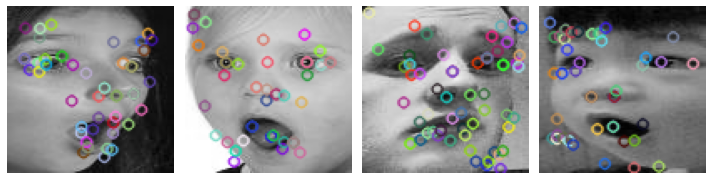

In [ ]:
#Code taken from Lab 07
# Initiate SIFT detector
sift = cv2.SIFT_create()

# Create empty lists for feature descriptors and labels
des_list = []
y_train_list = []

fig, ax = plt.subplots(1, 4, figsize=(10, 8), sharey=True)

for i in range(len(X_train)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    kp, des = sift.detectAndCompute(img, None) 

    # Show results for first 4 images
    if i<4:
        img_with_SIFT = cv2.drawKeypoints(img, kp, img)
        ax[i].imshow(img_with_SIFT)
        ax[i].set_axis_off()

    # Append list of descriptors and label to respective lists
    if des is not None:
        des_list.append(des)
        y_train_list.append(y_train[i])

fig.tight_layout()
plt.show()

# Convert to array for easier handling
des_array = np.vstack(des_list)

**Clustering of the descriptors using Kmeans**

In [ ]:
#Code taken from Lab 07
import numpy as np
# Number of centroids/codewords: good rule of thumb is 10*num_classes
k = len(np.unique(y_train)) * 10

# Use MiniBatchKMeans for faster computation and lower memory usage
batch_size = des_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)

**Generating histograms of codewords**

In [ ]:
#Code taken from Lab 07
# Convert descriptors into histograms of codewords for each image
hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)

**Plotting the overall histogram for the codewords**

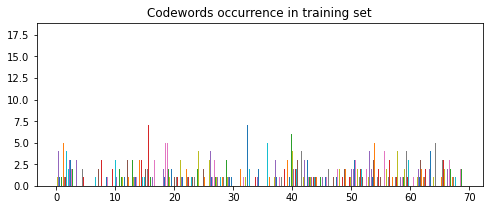

In [ ]:
#Code taken from Lab 07
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(np.array(idx_list, dtype=object), bins=k)
ax.set_title('Codewords occurrence in training set')
plt.show()

**Training a SVM classifier with radial basis function kernel.**

In [ ]:
#Code taken from Lab 07
# Create a classifier: a support vector classifier
classifier = svm.SVC(kernel='rbf', C=10)
classifier.fit(hist_array, y_train_list)

SVC(C=10)

**Testing**

In [ ]:
#Code taken from Lab 07
hist_list_test = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    kp, des = sift.detectAndCompute(img, None)

    if des is not None:
        hist = np.zeros(k)

        idx = kmeans.predict(des)

        for j in idx:
            hist[j] = hist[j] + (1 / len(des))

        # hist = scale.transform(hist.reshape(1, -1))
        hist_list_test.append(hist)

    else:
        hist_list_test.append(None)

# Remove potential cases of images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list_test) if x is not None]
hist_list_test = [hist_list_test[i] for i in idx_not_empty]
y_test_svmsift = [y_test[i] for i in idx_not_empty]
hist_array_test = np.vstack(hist_list_test)

**Predicting**

In [ ]:
#Code taken from Lab 07
y_pred = classifier.predict(hist_array_test).tolist()

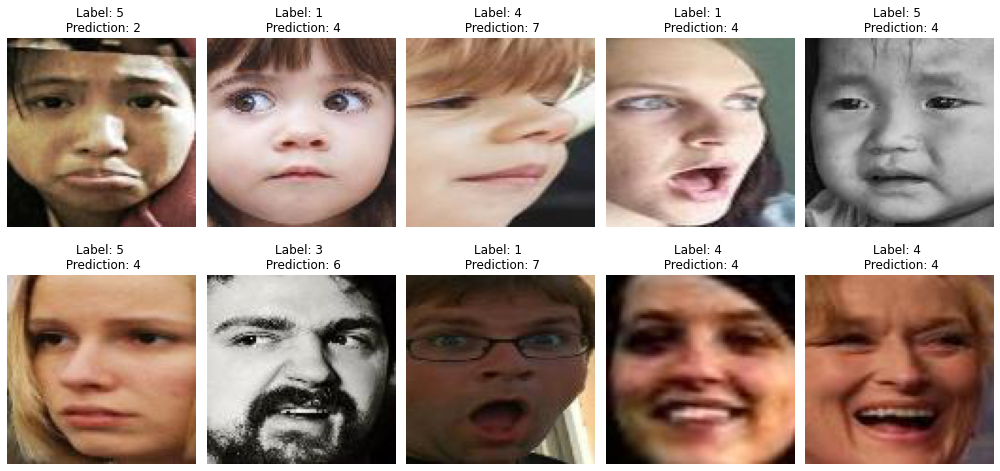

In [ ]:
#Code taken from Lab 07
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test_svmsift[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [ ]:
#Code taken from Lab 07
print(f"""Classification report for classifier {classifier}:
      {metrics.classification_report(y_test_svmsift, y_pred)}\n""")

Classification report for classifier SVC(C=10):
                    precision    recall  f1-score   support

           1       0.22      0.25      0.24       329
           2       0.07      0.24      0.11        74
           3       0.08      0.16      0.11       160
           4       0.45      0.48      0.46      1184
           5       0.23      0.11      0.15       478
           6       0.14      0.17      0.15       162
           7       0.29      0.19      0.23       679

    accuracy                           0.29      3066
   macro avg       0.21      0.23      0.21      3066
weighted avg       0.31      0.29      0.30      3066




**Hyperparameter Tuning**

In [ ]:
parameter_grid = {'kernel':["linear", "poly", "rbf"], 'C': [0.1, 1, 10], 'gamma':[ 0.01, 0.1,1 ]}
gridCV = GridSearchCV(SVC(),parameter_grid, verbose=1)

In [ ]:
gridCV.fit(hist_array, y_train_list)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1],
                         'kernel': ['linear', 'poly', 'rbf']},
             verbose=1)

In [ ]:
gridCV.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
gridCV.best_estimator_

SVC(C=10, gamma=1)

**Saving the Model**

In [ ]:
with open("Best_SIFT_SVM.pkl", mode ="ab") as f:
    pickle.dump(classifier, f)

In [ ]:
with open("Best_SIFT_SVM.pkl", "rb") as f:
    SIFT_SVM_Trained = pickle.load(f)

In [ ]:
final_pred = SIFT_SVM_Trained.predict(hist_array_test).tolist()

In [ ]:
print(f"""Final Classification Report {SIFT_SVM_Trained}:
      {metrics.classification_report(y_test_svmsift, final_pred)}\n""")

Final Classification Report SVC(C=10):
                    precision    recall  f1-score   support

           1       0.10      0.10      0.10       329
           2       0.05      0.24      0.08        74
           3       0.05      0.09      0.06       160
           4       0.36      0.29      0.32      1184
           5       0.16      0.07      0.10       478
           6       0.11      0.12      0.12       162
           7       0.26      0.27      0.26       679

    accuracy                           0.21      3066
   macro avg       0.15      0.17      0.15      3066
weighted avg       0.24      0.21      0.22      3066




# SVM - HOG

**Extracting feature descriptors using HOG**

In [ ]:
#Adapted from Lab 06
#Empty lists for images and feature descriptors
HOG_images = []
HOG_descs = []


for i in range(len(X_train)):
    # Identify keypoints and extract descriptors with SIFT
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    HOG_des, HOG_image = hog( img, orientations=8, pixels_per_cell=(16, 16),  cells_per_block=(1, 1), visualize=True)
    
    HOG_images.append(HOG_image)
    HOG_descs.append(HOG_des)

**Plotting HOG**

<Figure size 720x720 with 0 Axes>

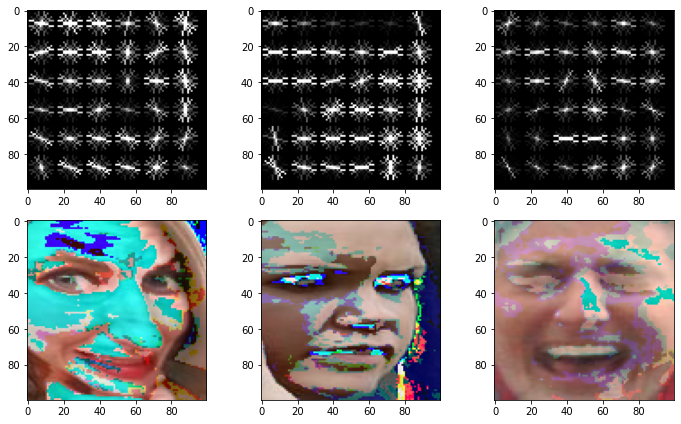

In [ ]:
#Adapted from Lab 06
plt.figure(figsize=(10, 10), linewidth=1)
fig, ax = plt.subplots(figsize=(10, 6), sharex=True, sharey=True)

for i in range(1,4):
  j = random.randint(1,10000)
  # Rescale histogram for better display
  HOG_image_rescaled = exposure.rescale_intensity(HOG_images[j], in_range=(0, 10))
  plt.subplot(2,3,i)
  plt.imshow(HOG_image_rescaled,cmap='gray')
  
  plt.subplot(2,3,3+i)
  plt.imshow(X_train[j])
  
fig.tight_layout()
plt.show()

**Initialise SVM classifier with its parameters**

In [ ]:
classifier_hogsvm = SVC()
#HOG_descs = np.array(HOG_descs)

classifier_hogsvm.fit(HOG_descs, y_train)

SVC()

**Creating a histogram of codewords**

In [ ]:
#Adapted from Lab 06 and Lab 07
# Convert descriptors into histograms of codewords for each image
hist_list_hogsvm = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    HOG_des, HOG_image = hog( img, orientations=8, pixels_per_cell=(16, 16),  cells_per_block=(1, 1), visualize=True)
    
    
    hist_list_hogsvm.append(HOG_des)

hist_array_hogsvm = np.vstack(hist_list_hogsvm)




In [ ]:
hist_list_hogsvm=np.array(hist_array_hogsvm)

**Predicting**

In [ ]:
y_pred_hogsvm = classifier_hogsvm.predict(hist_list_hogsvm)

**Evaluating the results**

<function matplotlib.pyplot.show(close=None, block=None)>

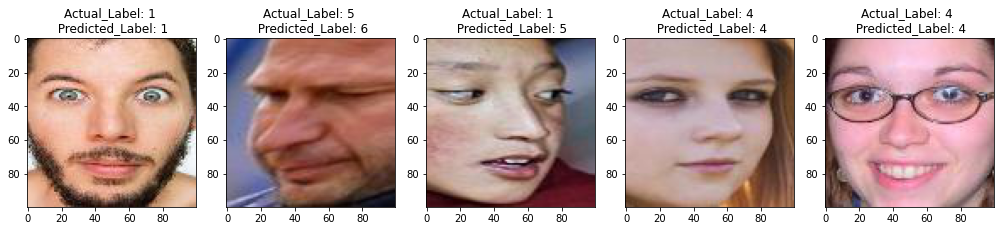

In [ ]:
plt.figure(figsize=(14, 11), linewidth=1)

for i in range(1,6):
  j = random.randint(1,100)
  plt.subplot(1,5,i)
  plt.imshow(X_test[j])
  plt.title(f'Actual_Label: {y_test[j]} \n Predicted_Label: {y_pred_hogsvm[j]}')

plt.tight_layout()
plt.show

In [ ]:
print(f"""Classification report for classifier {classifier_hogsvm}:
      {metrics.classification_report(y_test, y_pred_hogsvm)}\n""")

Classification report for classifier SVC():
                    precision    recall  f1-score   support

           1       0.53      0.53      0.53       329
           2       0.25      0.38      0.30        74
           3       0.17      0.23      0.20       160
           4       0.75      0.78      0.77      1185
           5       0.55      0.35      0.43       478
           6       0.37      0.43      0.40       162
           7       0.58      0.58      0.58       680

    accuracy                           0.59      3068
   macro avg       0.46      0.47      0.46      3068
weighted avg       0.59      0.59      0.59      3068




In [ ]:
np.array(y_test).shape

(3068,)

**Cross Validation and Hyperparameter Tuning**

In [ ]:
parameter_grid_hogsvm = {'kernel':["linear", "poly", "rbf"], 'C': [0.1, 1, 10], 'gamma':[0.01, 0.1,1 ]}
gridCV_hogsvm = GridSearchCV(SVC(), parameter_grid_hogsvm, verbose=1)

In [ ]:
gridCV_hogsvm.fit(HOG_descs, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1],
                         'kernel': ['linear', 'poly', 'rbf']},
             verbose=1)

In [ ]:
gridCV_hogsvm.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
gridCV_hogsvm.best_estimator_

SVC(C=10, gamma=1)

**Saving the model**

In [ ]:
with open("Best_HOG_SVM.pkl", mode ="ab") as f:
    pickle.dump(classifier_hogsvm, f)

In [ ]:
with open("Best_HOG_SVM.pkl", "rb") as f:
    HOG_SVM_Trained = pickle.load(f)

In [ ]:
final_pred_hogsvm = HOG_SVM_Trained.predict(hist_array_hogsvm).tolist()

In [ ]:
print(f"""Final Classification Report {HOG_SVM_Trained}:
      {metrics.classification_report(y_test, final_pred_hogsvm)}\n""")

Final Classification Report SVC():
                    precision    recall  f1-score   support

           1       0.53      0.53      0.53       329
           2       0.25      0.38      0.30        74
           3       0.17      0.23      0.20       160
           4       0.75      0.78      0.77      1185
           5       0.55      0.35      0.43       478
           6       0.37      0.43      0.40       162
           7       0.58      0.58      0.58       680

    accuracy                           0.59      3068
   macro avg       0.46      0.47      0.46      3068
weighted avg       0.59      0.59      0.59      3068




# MLP-HOG

**MLP Classifier Initialisation**

In [ ]:
classifier_mlphog = MLPClassifier(random_state=1, max_iter=100).fit(HOG_descs, y_train)

In [ ]:
y_pred_mlphog = classifier_mlphog.predict(hist_array_hogsvm).tolist()

<function matplotlib.pyplot.show(close=None, block=None)>

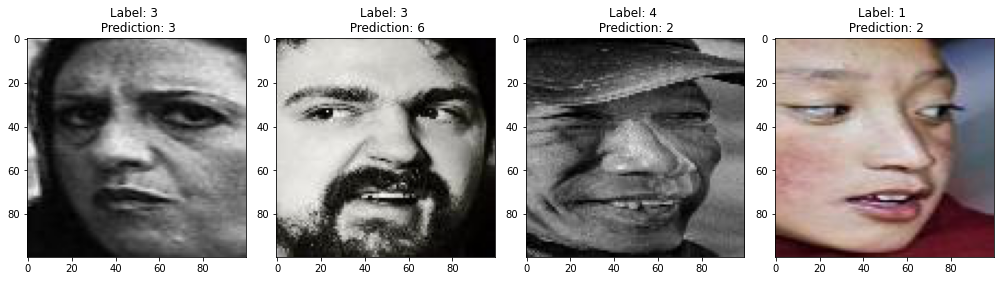

In [ ]:
plt.figure(figsize=(14, 11), linewidth=1)

for i in range(1,5):
  j = random.randint(1,100)
  plt.subplot(1,4,i)
  plt.imshow(X_test[j])
  plt.title(f'Label: {y_test[j]} \n Prediction: {y_pred_mlphog[j]}')

plt.tight_layout()
plt.show

In [ ]:
print(f"""Classification report for classifier {classifier_mlphog}:
      {metrics.classification_report(y_test, y_pred_mlphog)}\n""")

Classification report for classifier MLPClassifier(max_iter=100, random_state=1):
                    precision    recall  f1-score   support

           1       0.39      0.57      0.46       329
           2       0.17      0.45      0.24        74
           3       0.16      0.21      0.18       160
           4       0.80      0.66      0.73      1185
           5       0.41      0.46      0.43       478
           6       0.37      0.44      0.40       162
           7       0.57      0.39      0.46       680

    accuracy                           0.52      3068
   macro avg       0.41      0.45      0.42      3068
weighted avg       0.57      0.52      0.54      3068




In [ ]:
parameter_grid_mlphog = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
gridCV_mlphog = GridSearchCV(MLPClassifier(random_state=1, max_iter=100), parameter_grid_mlphog, verbose=1)

In [ ]:
gridCV_mlphog.fit(HOG_descs, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(estimator=MLPClassifier(max_iter=100, random_state=1),
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10, 30, 10), (20,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             verbose=1)

In [ ]:
gridCV_mlphog.best_params_

{'activation': 'tanh',
 'alpha': 0.0001,
 'hidden_layer_sizes': (10, 30, 10),
 'learning_rate': 'constant',
 'solver': 'adam'}

In [ ]:
gridCV_mlphog.best_estimator_

MLPClassifier(activation='tanh', hidden_layer_sizes=(10, 30, 10), max_iter=100,
              random_state=1)

In [ ]:
final_classifier_mlphog = MLPClassifier(random_state=1, max_iter=100,activation= 'tanh',
 alpha=0.0001,
 hidden_layer_sizes=(10, 30, 10),
 learning_rate='constant',
 solver= 'adam').fit(HOG_descs, y_train)

In [ ]:
final_pred_mlphog = final_classifier_mlphog.predict(hist_array_hogsvm).tolist()

In [ ]:
print(f"""Final Classification Report {final_classifier_mlphog}:
      {metrics.classification_report(y_test, final_pred_mlphog)}\n""")

Final Classification Report MLPClassifier(activation='tanh', hidden_layer_sizes=(10, 30, 10), max_iter=100,
              random_state=1):
                    precision    recall  f1-score   support

           1       0.47      0.47      0.47       329
           2       0.14      0.27      0.18        74
           3       0.12      0.29      0.17       160
           4       0.77      0.70      0.74      1185
           5       0.50      0.27      0.35       478
           6       0.26      0.56      0.35       162
           7       0.56      0.44      0.49       680

    accuracy                           0.51      3068
   macro avg       0.40      0.43      0.39      3068
weighted avg       0.57      0.51      0.53      3068




**Saving the Model**

In [ ]:
with open("Best_HOG_MLP.pkl", mode ="ab") as f:
    pickle.dump(final_classifier_mlphog, f)

In [ ]:
with open("Best_HOG_MLP.pkl", "rb") as f:
    HOG_MLP_Trained = pickle.load(f)

In [ ]:
final_pred_mlphog = HOG_MLP_Trained.predict(hist_array_hogsvm).tolist()

In [ ]:
print(f"""Final Classification Report {HOG_MLP_Trained}:
      {metrics.classification_report(y_test, final_pred_mlphog)}\n""")

Final Classification Report MLPClassifier(max_iter=100, random_state=1):
                    precision    recall  f1-score   support

           1       0.39      0.57      0.46       329
           2       0.17      0.45      0.24        74
           3       0.16      0.21      0.18       160
           4       0.80      0.66      0.73      1185
           5       0.41      0.46      0.43       478
           6       0.37      0.44      0.40       162
           7       0.57      0.39      0.46       680

    accuracy                           0.52      3068
   macro avg       0.41      0.45      0.42      3068
weighted avg       0.57      0.52      0.54      3068


